In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import scipy.io as sio
from scipy.interpolate import interp2d
import rppy

##### Combine co2sat, pressure and porosity into one dictionary


In [ ]:

reservoirProps = []
for ireal in range(40):
    temp = dict()
    
    sg = sio.loadmat('data/MRST_Outputs_Proc/s{}.mat'.format(ireal))['newS']
    pres = sio.loadmat('data/MRST_Outputs_Proc/s{}_pres.mat'.format(ireal))['newP']
    poro = np.load('data/perm_poro_maps/py_perm_poro/poro{}.npy'.format(ireal))
    perm = np.load('data/perm_poro_maps/py_perm_poro/perm{}.npy'.format(ireal))
    temp['co2sat'] = sg
    temp['pressure'] = pres
    temp['porosity'] = poro
    temp['permeability'] = perm
    reservoirProps.append(temp)
reservoirProps = np.array(reservoirProps)    
# np.save('general/reservoirProps.npy',reservoirProps)

#### Gassmann Fluid Substitution

In [6]:
def GassmannSg2Vp(sg,pres,poro,alpha,layer='sandstone'):
    
    
    mineral_fraction_sandstone = {'clay': 0.0, 'quartz': 0.7, 'feldspar':0.2, 'rock_fragments':0.1}
    mineral_fraction_shale = {'clay': 0.90, 'quartz': 0.10, 'feldspar':0.0, 'rock_fragments':0}
    mineral_density= {'clay': 2.5, 'quartz': 2.65, 'feldspar': 2.63, 'rock_fragments': 2.7} #g/cm3
    mineral_K = {'clay': 21, 'quartz': 36.6, 'feldspar':75.6, 'rock_fragments':80}
    mineral_G = {'clay': 9, 'quartz': 44, 'feldspar': 25.6, 'rock_fragments': 20}

    def M_viogt(f, M):      
            M_viogt = 0
            for i in range(len(f)):
                fi = f[i]
                mi = M[i]
                M_viogt  += fi*mi
            return M_viogt
    
    def M_reuss(f, M):
            M_reuss = 0
            for i in range(len(f)):
                fi = f[i]
                mi = M[i]
                M_reuss  +=  fi/mi
            return 1.0/M_reuss
        
    def K_sat(phi):
            part1 = (1 - K_dry/K_matrix)**2
            part2 = phi / K_fluid
            part3 = (1-phi)/K_matrix
            part4 = K_dry / (K_matrix)**2
            K_saturation = K_dry + (part1/(part2 + part3 - part4 ))
    
            return K_saturation
    
    def K_dry_pride(phi, alpha=alpha):
            """
            Eq 11 in Zhong 2020
            """
            #Pride 2005 model 
            #Pride, S.R., 2005, Relationships between seismic and hydrological properties, in Rubin, Y., and Hubbard, S., eds., Hydrogeophysics: New York, Kluwer Academy, p. 217–255
            K_dry = K_matrix*(1.0-phi)/(1.0+alpha*phi)
            return K_dry
        
    def matrix_density_sandstone():
    
        rho_mineral = 0
        for each_mineral in mineral_density.keys():
            rho_mineral += mineral_fraction_sandstone[each_mineral] * mineral_density[each_mineral]
        return rho_mineral
    
    
    def matrix_density_shale():
    
        rho_mineral = 0
        for each_mineral in mineral_density.keys():
            rho_mineral += mineral_fraction_shale[each_mineral] * mineral_density[each_mineral]
        return rho_mineral
    
    def calculate_bulk_density(phi):
        bulk_density = (phi * rho_fluid) + (1-phi)* rho_matrix
        return bulk_density
    
    if layer == 'sandstone':
        f_layer = []
        K = []
        G = []
        for each_mineral, each_module in zip(mineral_K.keys(), mineral_K.values()):
            f_layer.append(mineral_fraction_sandstone[each_mineral])
            K.append(mineral_K[each_mineral])
            G.append(mineral_G[each_mineral]) 
        
        K_viogt = M_viogt(f_layer, K)
        K_reuss = M_reuss(f_layer, K)
        K_matrix = 0.5*(K_viogt + K_reuss)
        rho_matrix = matrix_density_sandstone() #g/cm3
        G_dry = 7.0
        
    elif layer == 'shale':
        f_layer = []
        K = []
        G = []
        for each_mineral, each_module in zip(mineral_K.keys(), mineral_K.values()):
            f_layer.append(mineral_fraction_shale[each_mineral])
            K.append(mineral_K[each_mineral])
            G.append(mineral_G[each_mineral]) 
        K_viogt = M_viogt(f_layer, K)
        K_reuss = M_reuss(f_layer, K)
        K_matrix = 0.5*(K_viogt + K_reuss)
        rho_matrix = matrix_density_shale() #g/cm3
        G_dry = 4.3
    
    sw = 1-sg
    K_dry = K_dry_pride(poro,alpha=alpha)
    
    T = 70 
    S = 155000.0 
    G = 1.5189
    
    brine_prop = rppy.fluid.batzle_wang(pres, T, 'brine', S=S)
    gas_prop   = rppy.fluid.batzle_wang(pres, T, 'gas', G=G)
    rho_brine = brine_prop['rho']
    vp_brine = brine_prop['Vp']
    rho_gas = gas_prop['rho']
    rho_w = sw * rho_brine
    rho_g = sg * rho_gas
    K_brine = rho_brine * (vp_brine**2) * 1e-6
    K_gas   = gas_prop['K'] #In MPa
    K_gas = K_gas/1000 #In GPa
    K_fl_invert = sw/K_brine + sg/K_gas
    K_fluid = (1.0/K_fl_invert) #in GPa
    rho_fluid =  rho_w + rho_g ## fluid density in g/cm3
    
    K_saturation  = K_sat(poro)
    bulk_density  = calculate_bulk_density(poro)

    Vp_Sat = np.sqrt((K_saturation + (4/3)*G_dry)/bulk_density)

    return Vp_Sat

In [5]:
reservoirProps = np.load('data/general/reservoirProps.npy',allow_pickle=True)

In [11]:
def create_mask():
    nx = 48
    mask = np.ones((45,nx))
    gradient = -0.31
    yStarting = 28
    thickness = 10
    for j in range(yStarting,yStarting+thickness+1): 
        for i in range(nx): 
           new_y = round((gradient * i) +j);
           mask[new_y,i] = 0
    return mask

mask = create_mask()

def correctVpConv(co2,pres,poro):
    alpha = 15
    ## zeros is sandstone, ones is shale
    vpallshale = GassmannSg2Vp(co2,pres,poro,alpha,layer='shale')
    vp_correct = GassmannSg2Vp(co2,pres,poro,alpha,layer='sandstone')
    vp_correct[np.where(mask==1)] = vpallshale[np.where(mask==1)]
    return vp_correct


vp_all = []
co2_arr = []
for ireal in range(40):
    
    #Convert VP
    reservoir = reservoirProps[ireal]
    co2_all = reservoir['co2sat']
    poro_all = reservoir['porosity']
    pres_all = reservoir['pressure']
    middle = 16
    co2_flat = co2_all[:,middle,:,:].swapaxes(1,2)
    pres_flat = pres_all[:,middle,:,:].swapaxes(1,2)
    poro = poro_all[middle,:,:].T
    
    temp_vel = []
    temp_co2 = []
    
    #start from index 9 onwards because the realizations before are bad!
    for it in range(co2_flat.shape[0]):
        pres = (pres_flat[it] + (1000*10*1.6215e3)) / 1e6 #correct for hydrostatic pressure
        
        if it==0:
            sg = np.zeros((45,48))
            vel0 = correctVpConv(sg,pres,poro)
            vel_diff = vel0   
        else:
            sg = co2_flat[it]
            vel = correctVpConv(sg,pres,poro)
            vel_diff = vel-vel0
        temp_vel.append(vel_diff)
        co2_timeslice = co2_flat[it]
        temp_co2.append(co2_timeslice)

    temp_vel = np.array(temp_vel)
    temp_co2 = np.array(temp_co2)
    
    vp_all.append(temp_vel)
    co2_arr.append(temp_co2)
   
vp_all = np.array(vp_all)
co2_arr = np.array(co2_arr)

In [12]:
#crop from index 9 onwards!
vp_all = vp_all[:,9:,:,:]
co2_arr = co2_arr[:,9:,:,:]

In [ ]:
# np.save('general/vp_all.npy',vp_all)
# np.save('general/co2_all.npy',co2_arr)

#### Check

In [ ]:
vp_all = np.load('general/vp_all.npy')
co2_arr =np.load('general/co2_all.npy')

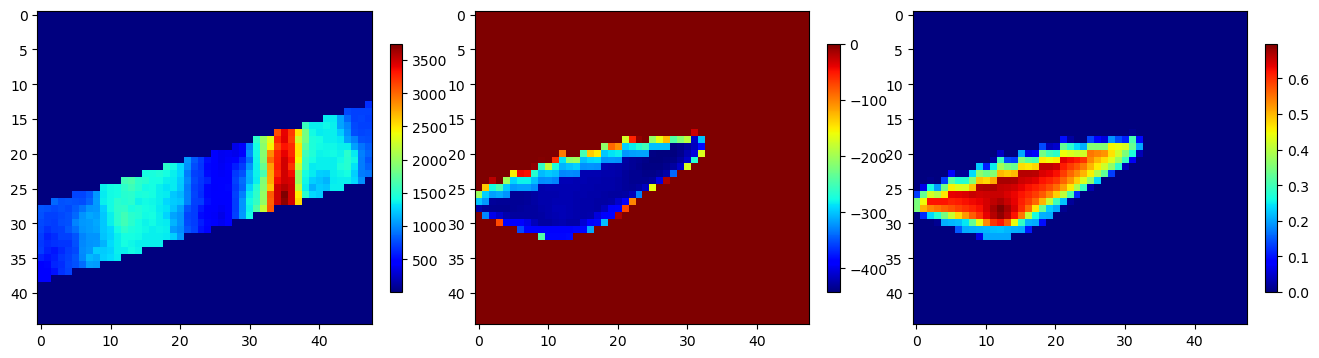

In [13]:
# see one vp
n1 = np.random.randint(40)
n2 = np.random.randint(39)
fig, axs = plt.subplots(1,3,figsize=(16,5))
a0 = reservoirProps[n1]['permeability'][16].T
a = vp_all[n1,n2,:,:]*1000
b = co2_arr[n1,n2]
im0 = axs[0].imshow(a0,cmap='jet')
im1 = axs[1].imshow(a,cmap='jet')
im2 = axs[2].imshow(b,cmap='jet')
fig.colorbar(im0, ax=axs[0],fraction=0.034)
fig.colorbar(im1, ax=axs[1],fraction=0.034)
fig.colorbar(im2, ax=axs[2],fraction=0.034)


In [15]:
print(vp_all.shape)

(40, 39, 45, 48)


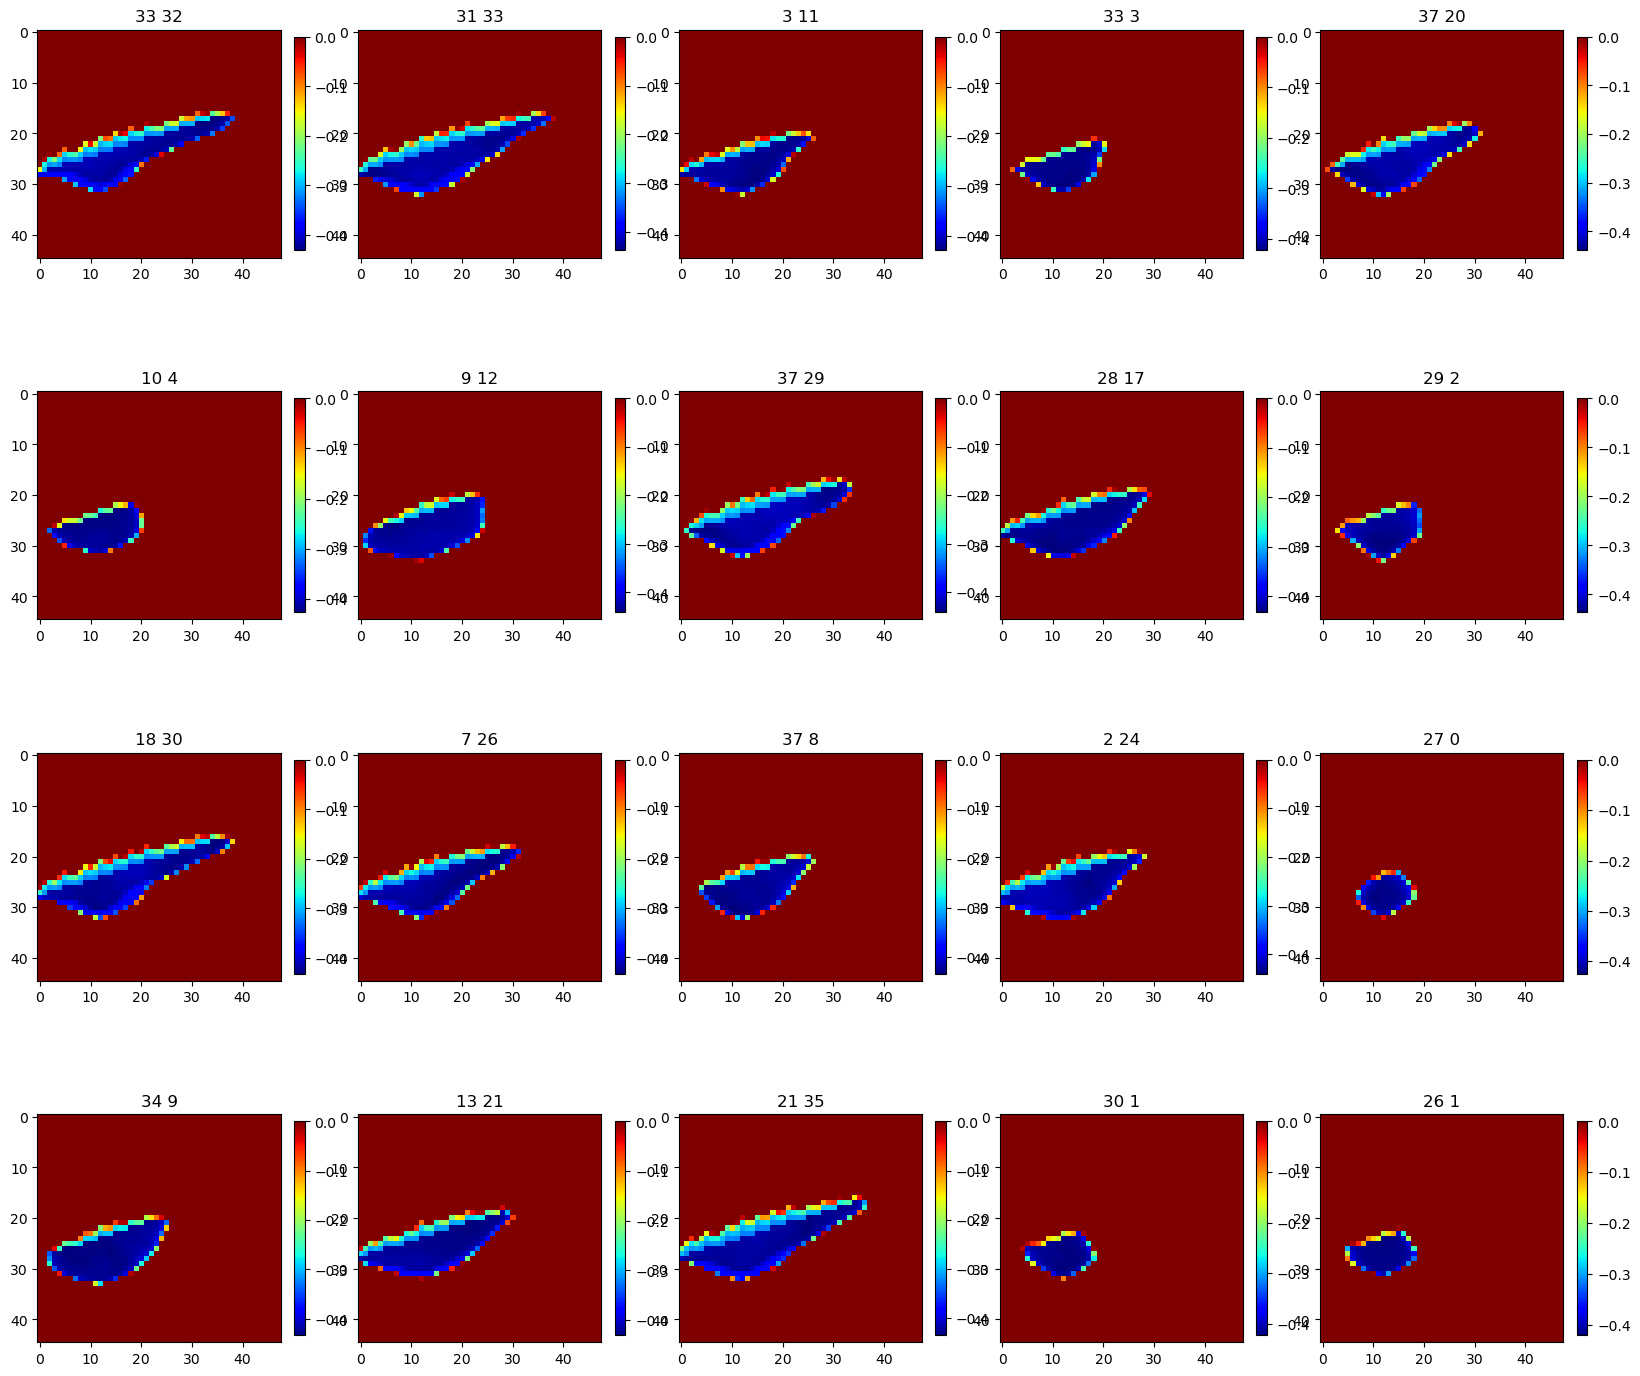

In [16]:
# see multiple random
c = 0
fig, axs = plt.subplots(4,5,figsize=(20,18))
for i in range(4):
    for j in range(5):
        n1 = np.random.randint(40)
        n2 = np.random.randint(39)
        slice2d = vp_all[n1,n2,:,:]
        ax = axs[i,j]
        ax.set_title('{} {}'.format(n1,n2))
        im = ax.imshow(slice2d, cmap='jet')
        cbar = plt.colorbar(im, ax=ax,fraction=0.04)
        c = c+1